In [1]:
import pickle
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt
from gurobipy import GRB
from plots import *
from ems_data import *
from simulation import *
from neural_network import *
from mip_models import *

TRAINING_METRICS = ['coverage_9min', 'coverage_15min', 'survival_rate', 'response_time_mean', 'response_time_median', 'response_time_90th_percentile']
FACILITY_CAPACITY = 5
TIME_LIMIT = 60  # Set to 600 for final results
SUCCESS_PROB = 0.9

def plot_metric(X: np.ndarray, y: np.ndarray, metric: str):
    """Plot histogram and box plots side by side."""
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].hist(y, bins=100)
    ax[0].set_xlabel(metric)
    ax[0].set_ylabel("Frequency")
    plot_metric_by_ambulance_count(X, y, metric, ax=ax[1])
    return fig, ax

def best_solution_from_dataset(dataset: pd.DataFrame, n_ambulances: int, metric: str) -> tuple[pd.Series, pd.Series]:
    """Finds the best solution w.r.t. a metric for a given maximum number of ambulances."""
    Y = dataset[METRICS]
    X = dataset.drop(columns=METRICS)
    indices = np.where(X.sum(axis=1) <= n_ambulances)[0]
    argmin_or_argmax = np.argmin if 'response_time' in metric else np.argmax
    y = Y[metric]
    best_idx = indices[argmin_or_argmax(y[indices])]
    return X.iloc[best_idx], Y.iloc[best_idx]

def remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='right'):
    """For each total number of ambulances, isolate samples with that total and remove outliers.

    Parameters
    ----------
    X, y : np.ndarray
        The dataset.
    
    percent : int, optional
        Percentage of data to remove.
    
    tail : {'left', 'right', 'both'}, optional
        Which tail to remove outliers from.

        For maximization problems, use 'left'. For minimization problems, use 'right'.

    Returns
    -------
    X_new, y_new : np.ndarray
        The dataset with outliers removed.
    """
    X_sum = X.sum(axis=1)
    min_ambulances = X_sum.min()
    max_ambulances = X_sum.max()
    keep = np.full(X.shape[0], False)
    for total in range(min_ambulances, max_ambulances+1):
        left_threshold = -np.inf
        right_threshold = np.inf
        if tail == 'right':
            right_threshold = np.percentile(y[X_sum == total], 100-percent)
        elif tail == 'left':
            left_threshold = np.percentile(y[X_sum == total], percent)
        elif tail == 'both':
            left_threshold = np.percentile(y[X_sum == total], percent/2)
            right_threshold = np.percentile(y[X_sum == total], 1 - percent/2)
        keep |= (X_sum == total) & (left_threshold < y) & (y < right_threshold)
    return X[keep], y[keep]

def rescale(x: np.ndarray, min: float = 0, max: float = 1) -> np.ndarray:
    """Shift and scale data to the range [min, max]."""
    return (x - x.min()) / (x.max() - x.min()) * (max - min) + min

print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
device

NVIDIA GeForce GTX 1070


device(type='cuda')

# stations: 46
# demand nodes: 2977


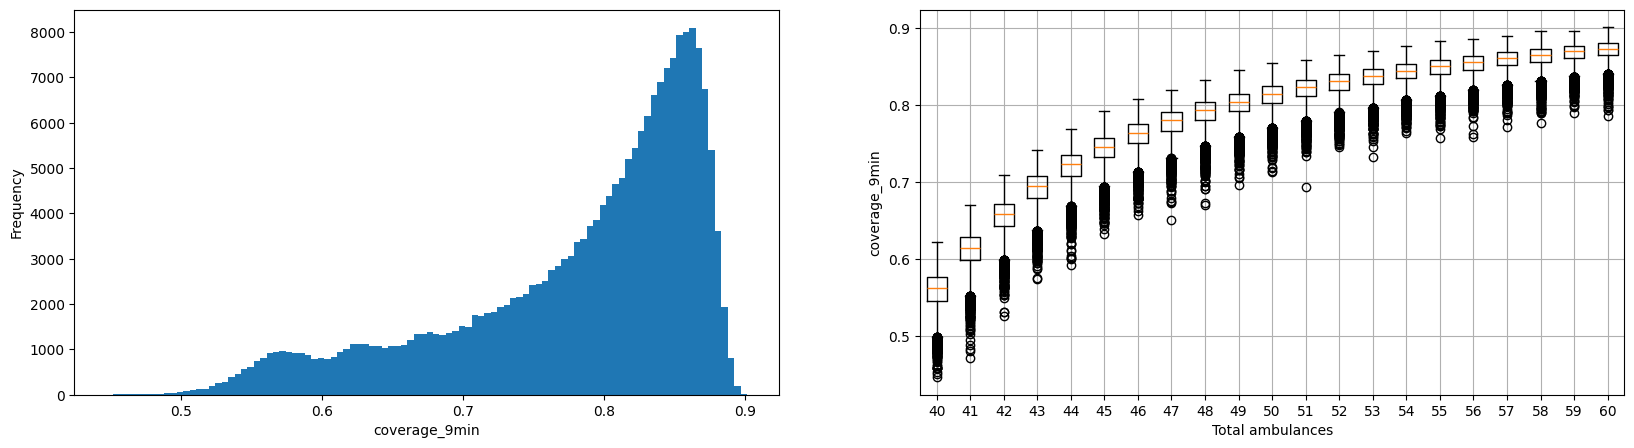

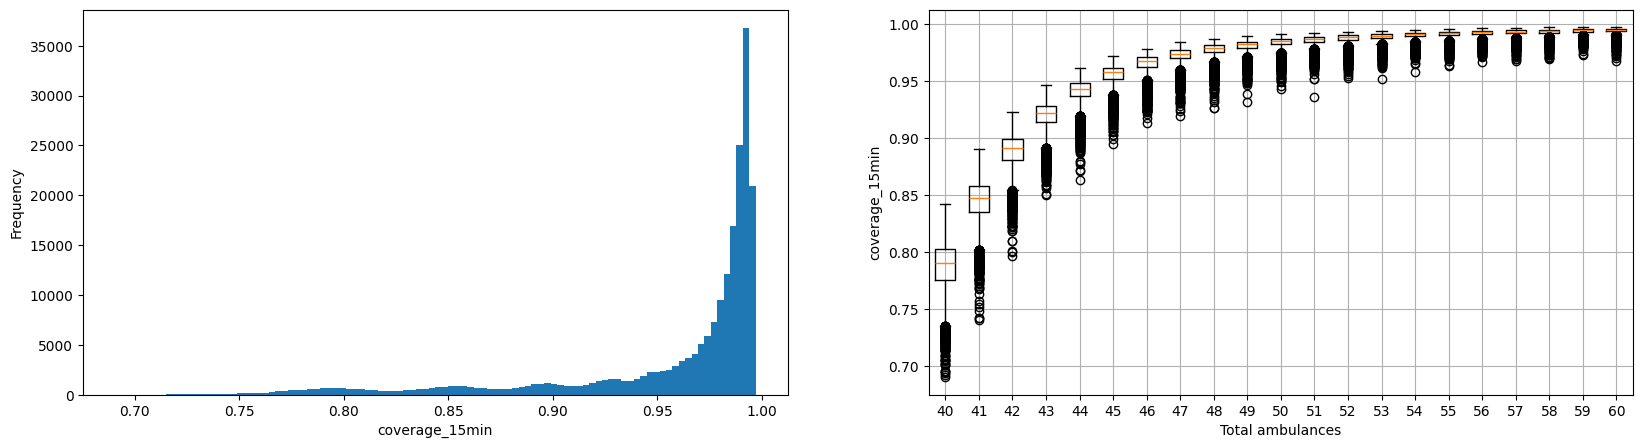

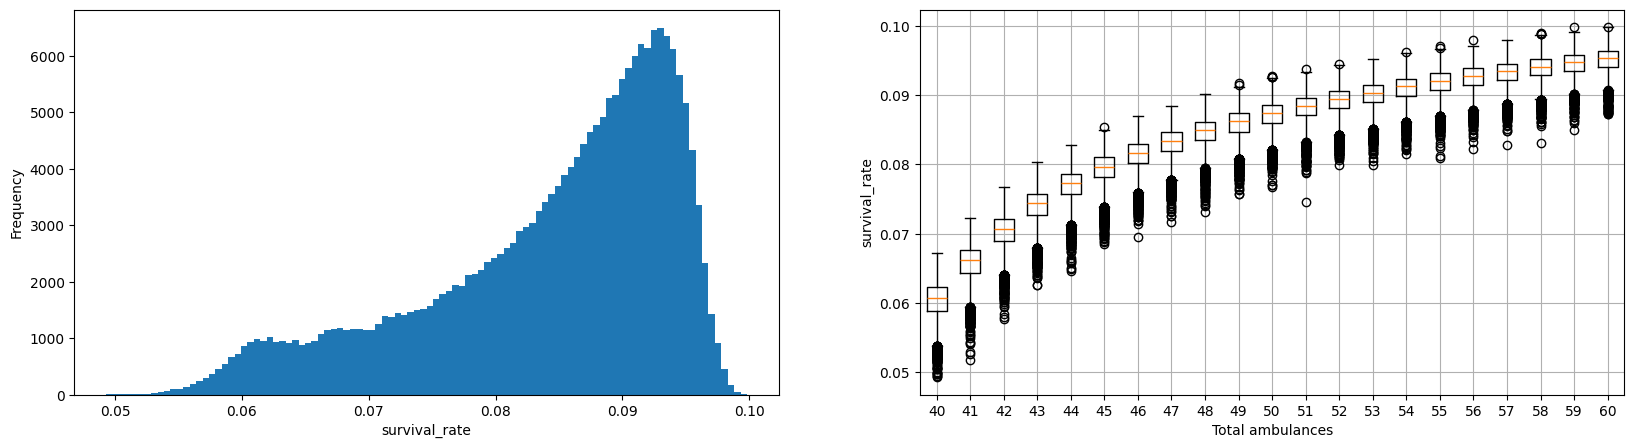

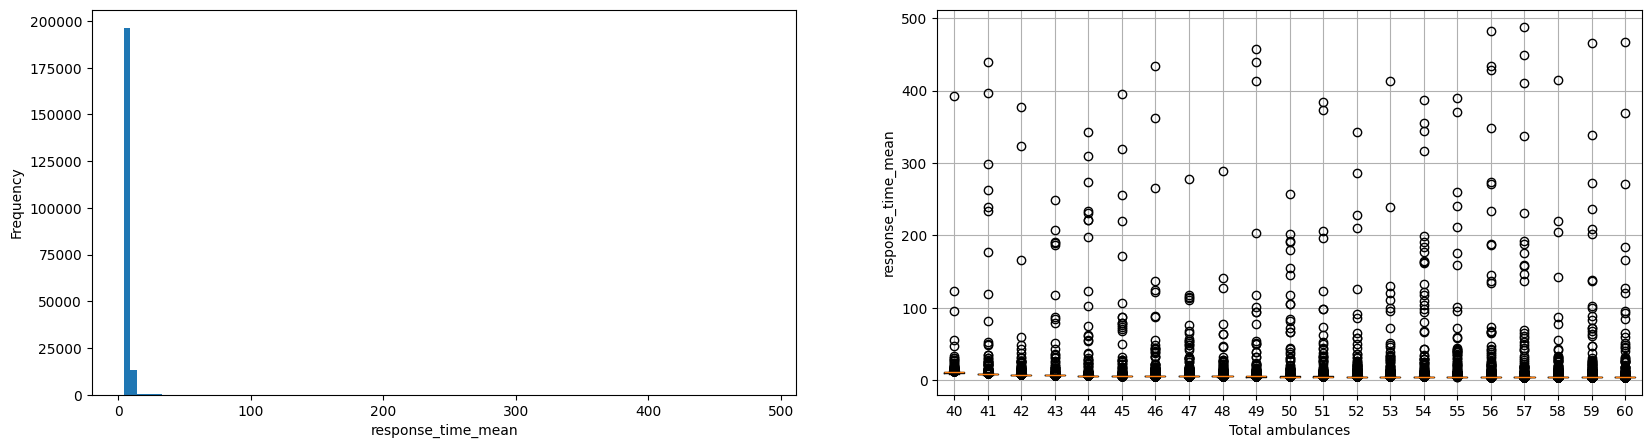

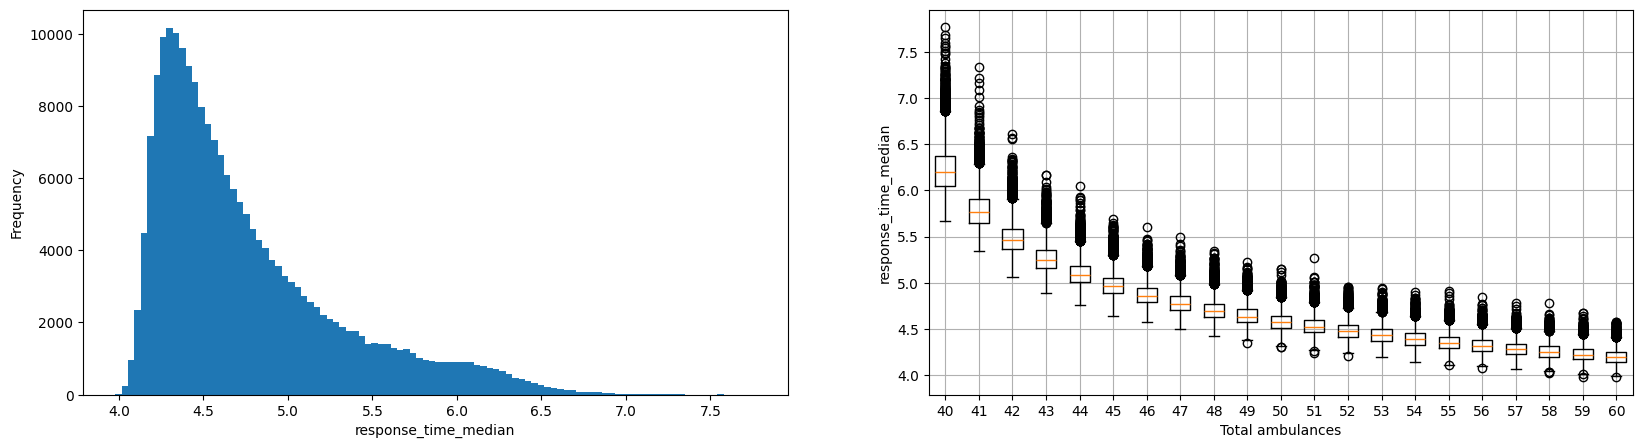

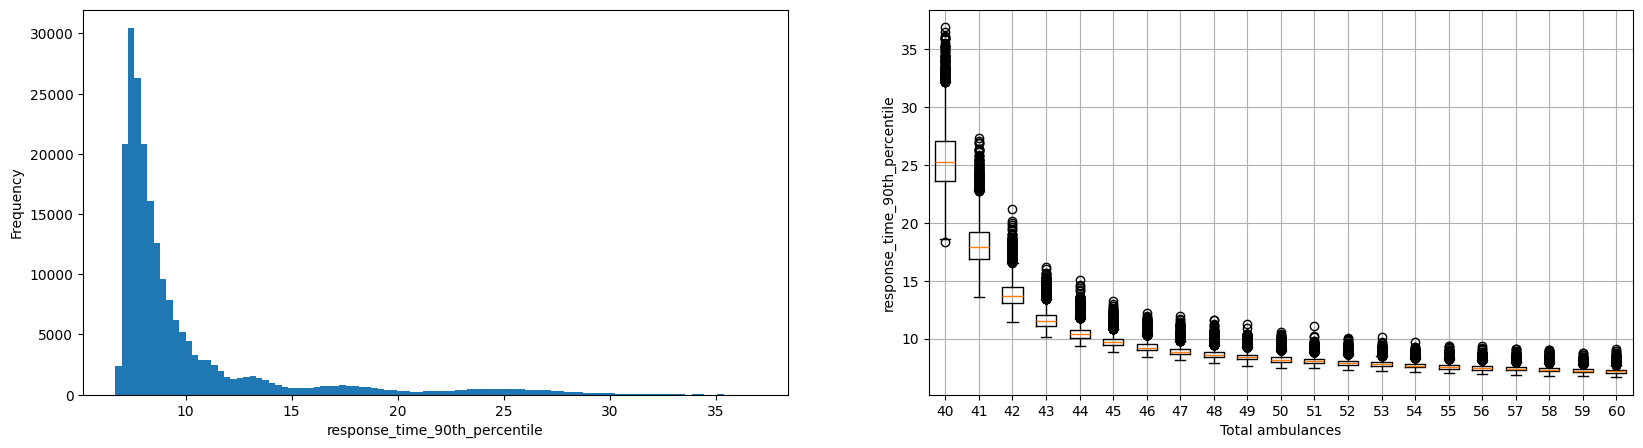

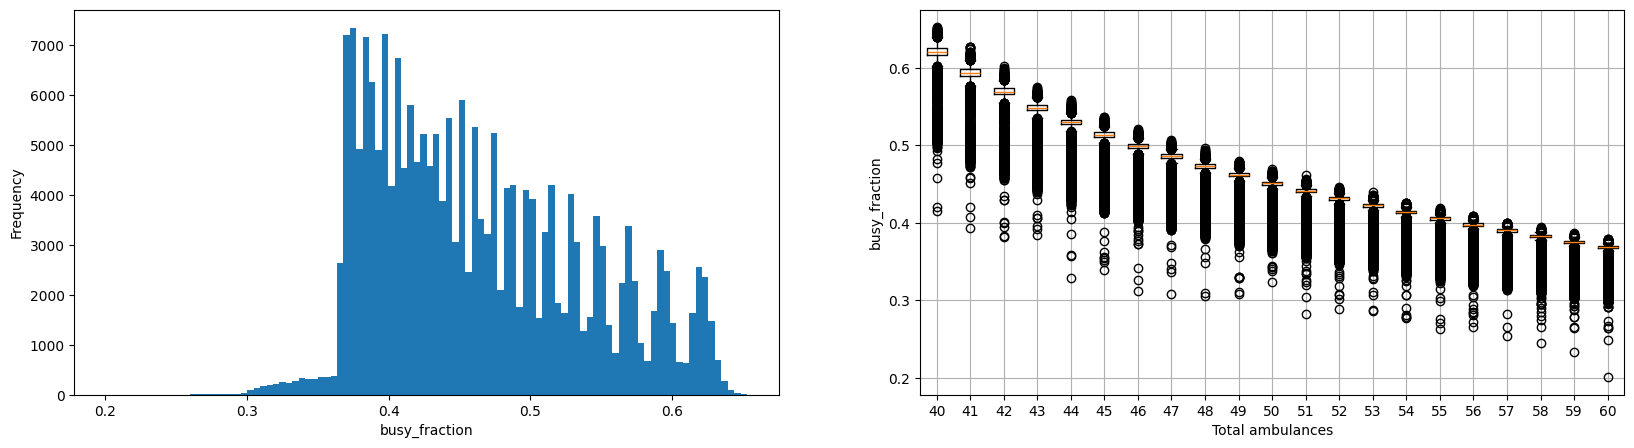

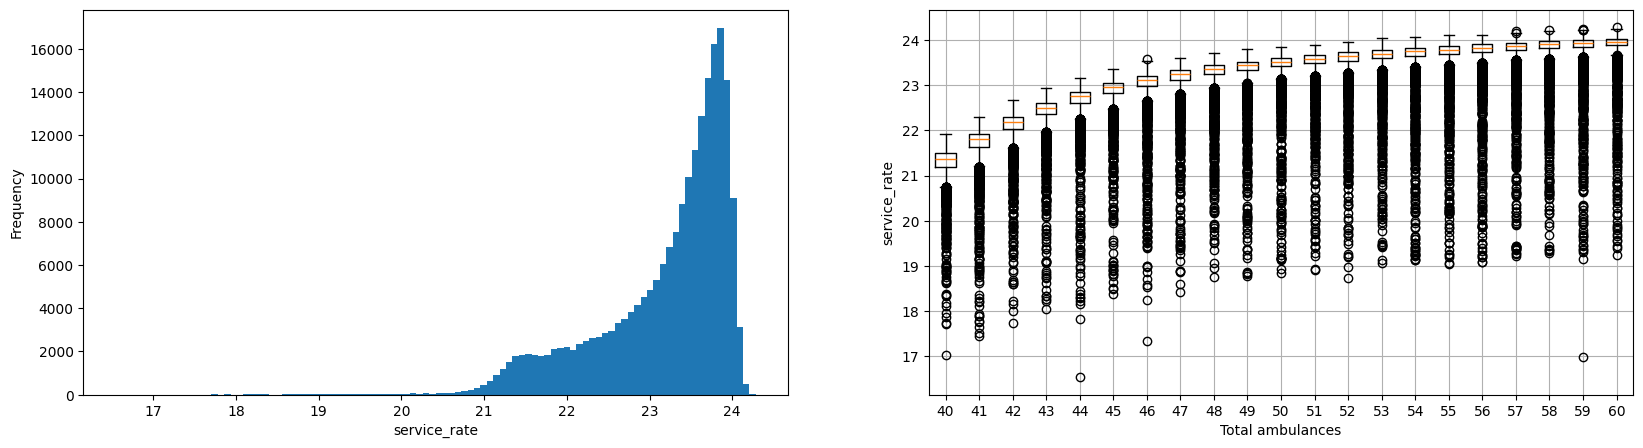

In [2]:
N_AMBULANCES = 50  # 43, 50, 57

region_id = 1
with open('ems_data.pkl', 'rb') as f:
    ems_data = pickle.load(f)
ems_data.region_id = region_id
demand_nodes = EMSData.read_patient_locations(region_id, test_id=0)
n_stations = len(ems_data.stations)
n_demand_nodes = len(demand_nodes)
print(f"# stations: {n_stations}")
print(f"# demand nodes: {n_demand_nodes}")
distance = Simulation.driving_distance(demand_nodes, ems_data.stations)
sim = Simulation(ems_data, n_days=100, n_replications=5)

dataset = pd.read_csv(f'dataset{region_id}.csv')
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()

for metric in METRICS:
    y = Y[:, METRICS.index(metric)]
    plot_metric(X, y, metric)

In [3]:
# Estimate busy_fraction and service_rate
BUSY_FRACTION = {}
SERVICE_RATE = {}
for n_ambulances in [43, 50, 57]:
    # Busy fraction used by MEXCLP so estimate using best w.r.t. coverage_9min
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'coverage_9min')
    BUSY_FRACTION[n_ambulances] = y['busy_fraction']
    # Service rate used by p-median + queueing model so estimate using best w.r.t. response_time_mean
    _, y = best_solution_from_dataset(dataset, n_ambulances, 'response_time_mean')
    SERVICE_RATE[n_ambulances] = y['service_rate']
print(f"BUSY_FRACTION = {BUSY_FRACTION}\nSERVICE_RATE = {SERVICE_RATE}")

BUSY_FRACTION = {43: 0.5378511773938689, 50: 0.4369429489820591, 57: 0.3874100103626275}
SERVICE_RATE = {43: 22.94662688807342, 50: 23.824098402950032, 57: 24.11136495764099}


# Baselines
- Best solutions from the dataset w.r.t `coverage_9min`, `survival_rate`, `response_time_mean`
- MEXCLP
- $p$-Median with queueing

In [4]:
all_results = []  # Columns: ['model_name', 'n_ambulances', *METRICS]

In [5]:
# Best solutions from dataset
for metric in ['coverage_9min', 'survival_rate', 'response_time_mean']:
    x, y = best_solution_from_dataset(dataset, N_AMBULANCES, metric)
    model_name = f'best_{metric}'
    n_ambulances = x.sum()
    new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
    all_results.append(new_row)

In [6]:
# MEXCLP
solution = mexclp(
    n_ambulances=N_AMBULANCES,
    distance=distance,
    threshold=MEXCLP_THRESHOLD_9MIN,
    busy_fraction=BUSY_FRACTION[N_AMBULANCES],
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-17
Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2978 rows, 148896 columns and 153997 nonzeros
Model fingerprint: 0x7496a2bf
Variable types: 0 continuous, 148896 integer (148850 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e-22, 2e-04]
  Bounds range     [1e+00, 5e+00]
  RHS range        [5e+01, 5e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 230 rows and 123755 columns
Presolve time: 0.09s
Presolved: 2748 rows, 25141 columns, 30242 nonzeros
Variable types: 0 continuous, 25141 integer (25095 binary)
Found heuristic solution: objective 0.3275814

Root relaxation: objective 7.214170e-01, 15463 iterations, 0.63 seco

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.854808,0.989942,0.093413,4.680789,4.253630,7.554993,0.450331,23.785522
1,0.859769,0.990166,0.094122,4.628374,4.217187,7.459724,0.441653,23.977195
2,0.856175,0.990785,0.093569,4.659727,4.250095,7.500777,0.447156,24.012959
3,0.851642,0.988513,0.093136,4.698674,4.259725,7.575675,0.443612,23.757415
4,0.859756,0.990515,0.094017,4.641179,4.228487,7.448512,0.442824,23.931208


In [7]:
model_name = 'MEXCLP'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

In [8]:
# p-Median with queuing
solution = pmedian_with_queuing(
    n_ambulances=N_AMBULANCES,
    distance=distance,
    arrival_rate=ems_data.avg_calls_per_day,
    service_rate=SERVICE_RATE[N_AMBULANCES],
    success_prob=SUCCESS_PROB,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 140150 rows, 137172 columns and 548596 nonzeros
Model fingerprint: 0xd55bdca6
Variable types: 136942 continuous, 230 integer (230 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+01]
  Objective range  [5e-06, 2e-02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+01]
Presolve time: 0.56s
Presolved: 140150 rows, 137172 columns, 548596 nonzeros
Variable types: 136942 continuous, 230 integer (230 binary)
Found heuristic solution: objective 5.7583094
Deterministic concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Root barrier log...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 46
 AA' NZ     : 5.485e+05
 Factor NZ  : 8.676e+05 (roughly

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.655148,0.953927,0.067878,6.443231,5.740259,10.625256,0.474400,22.426066
1,0.661143,0.957681,0.068520,6.380083,5.714707,10.522489,0.469558,22.504250
2,0.652025,0.953684,0.067761,6.457762,5.760942,10.650284,0.475688,22.321200
3,0.650490,0.952617,0.067586,6.472140,5.764267,10.672104,0.474964,22.371988
4,0.654826,0.953331,0.068058,6.436546,5.740466,10.590937,0.475638,22.356263


In [9]:
model_name = 'p-Median + Queueing'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

In [10]:
# Results so far
pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
1,best_survival_rate,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
2,best_response_time_mean,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
3,MEXCLP,50,0.856430,0.989984,0.093651,4.661749,4.241825,7.507936,0.445115,23.892860
4,p-Median + Queueing,50,0.654726,0.954248,0.067960,6.437952,5.744128,10.612214,0.474050,22.395953


# Coverage

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='coverage_9min (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='coverage_9min (transformed)'>],
       dtype=object))

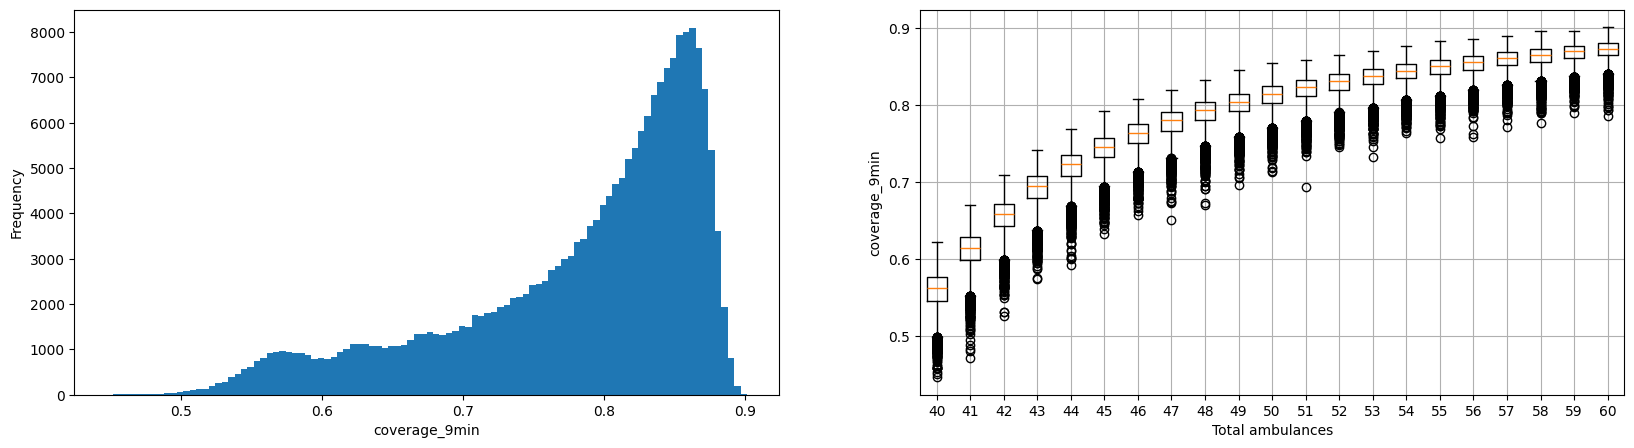

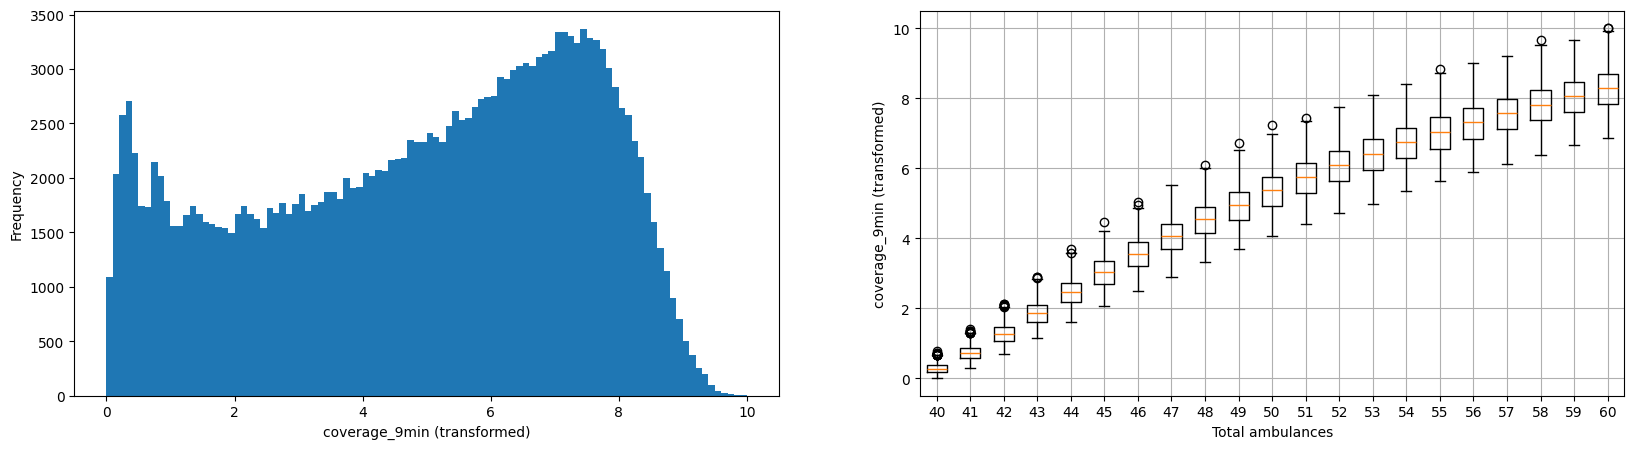

In [11]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'coverage_9min'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='left')
y = scipy.stats.boxcox(y)[0]
# Box-Cox transformation generally turns probabilities into negative values with a small range
# The modified sigmoid function is only nonlinear for positive values
# To deal with negative values and increase the range, we shift and scale
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [12]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    final_hidden_activation=ModifiedSigmoid(),
    name='toronto_coverage'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 88%|████████▊ | 88/100 [05:44<00:46,  3.91s/epoch, best_val_loss=0.00805, train_loss=0.009, val_loss=0.0118]   


Early stopping


 40%|████      | 40/100 [02:27<03:40,  3.68s/epoch, best_val_loss=0.00634, train_loss=0.00609, val_loss=0.00634]

Early stopping


In [13]:
weights, biases = MLP.load_npz('toronto_coverage.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3651 rows, 1292 columns and 56144 nonzeros
Model fingerprint: 0x6c5dee78
Variable types: 1046 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [2e-07, 6e+01]
  Objective range  [8e-02, 1e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [2e-03, 6e+01]
Presolve removed 469 rows and 250 columns
Presolve time: 0.07s
Presolved: 3182 rows, 1042 columns, 55406 nonzeros
Variable types: 798 continuous, 244 integer (198 binary)

Root relaxation: objective 1.278438e+01, 885 iterations, 0.07 seconds (0.16 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.78438 

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.860478,0.991556,0.094441,4.611679,4.216009,7.417506,0.442054,23.881085
1,0.858827,0.990884,0.094105,4.632797,4.221351,7.450442,0.448271,23.821511
2,0.860769,0.991188,0.094423,4.610675,4.213186,7.381356,0.444801,23.921488
3,0.857597,0.989983,0.094172,4.649036,4.235763,7.449104,0.445215,23.892222
4,0.861747,0.990668,0.094256,4.620696,4.224141,7.381451,0.445238,23.861293


In [14]:
model_name = 'MLP-Coverage'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
1,best_survival_rate,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
2,best_response_time_mean,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
3,MEXCLP,50,0.856430,0.989984,0.093651,4.661749,4.241825,7.507936,0.445115,23.892860
4,p-Median + Queueing,50,0.654726,0.954248,0.067960,6.437952,5.744128,10.612214,0.474050,22.395953
5,MLP-Coverage,50,0.859884,0.990856,0.094279,4.624977,4.222090,7.415972,0.445116,23.875520


# Survival

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='survival_rate (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='survival_rate (transformed)'>],
       dtype=object))

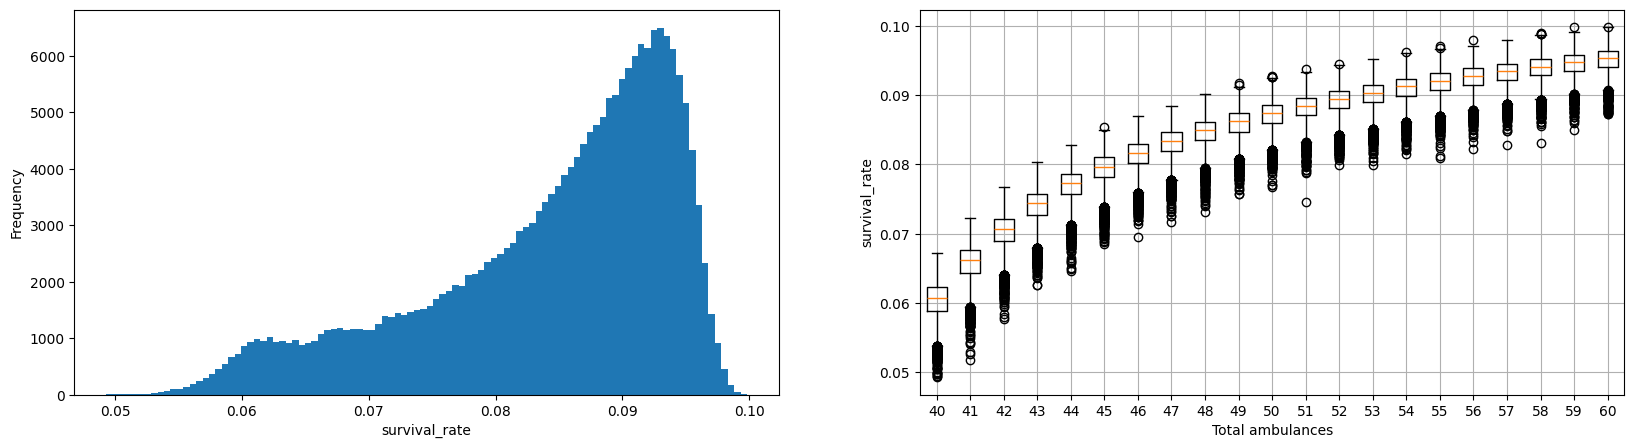

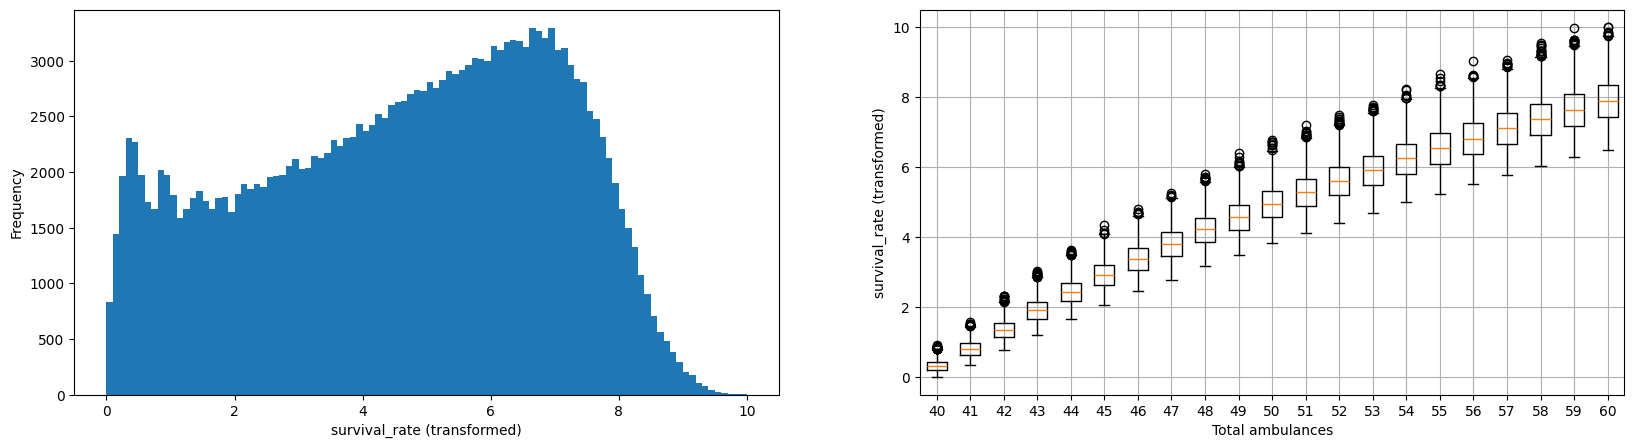

In [15]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'survival_rate'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='left')
y = scipy.stats.boxcox(y)[0]
# Box-Cox transformation generally turns probabilities into negative values with a small range
# The modified sigmoid function is only nonlinear for positive values
# To deal with negative values and increase the range, we shift and scale
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [16]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    final_hidden_activation=ModifiedSigmoid(),
    name='toronto_survival'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 59%|█████▉    | 59/100 [04:12<02:55,  4.28s/epoch, best_val_loss=0.0433, train_loss=0.139, val_loss=0.0467]


Early stopping


 43%|████▎     | 43/100 [02:36<03:27,  3.65s/epoch, best_val_loss=0.0069, train_loss=0.00669, val_loss=0.0069]  

Early stopping


In [17]:
weights, biases = MLP.load_npz('toronto_survival.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MAXIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 3647 rows, 1292 columns and 56138 nonzeros
Model fingerprint: 0xc6c556d9
Variable types: 1046 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [9e-07, 5e+01]
  Objective range  [2e-01, 2e-01]
  Bounds range     [1e+00, 5e+00]
  RHS range        [3e-03, 5e+01]
Presolve removed 516 rows and 246 columns
Presolve time: 0.09s
Presolved: 3131 rows, 1046 columns, 55306 nonzeros
Variable types: 800 continuous, 246 integer (200 binary)

Root relaxation: objective 1.299756e+01, 1043 iterations, 0.08 seconds (0.19 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   12.99756

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.859713,0.991430,0.094639,4.608531,4.208435,7.424958,0.442608,23.972344
1,0.861738,0.991559,0.094949,4.593678,4.196989,7.406621,0.446451,23.872124
2,0.860602,0.991282,0.094588,4.616232,4.207109,7.451676,0.443562,23.931059
3,0.858773,0.990430,0.094746,4.616618,4.195960,7.473112,0.444623,23.958828
4,0.859555,0.990532,0.094827,4.643639,4.202832,7.439356,0.425859,23.819993


In [18]:
model_name = 'MLP-Survival'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
1,best_survival_rate,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
2,best_response_time_mean,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
3,MEXCLP,50,0.856430,0.989984,0.093651,4.661749,4.241825,7.507936,0.445115,23.892860
4,p-Median + Queueing,50,0.654726,0.954248,0.067960,6.437952,5.744128,10.612214,0.474050,22.395953
5,MLP-Coverage,50,0.859884,0.990856,0.094279,4.624977,4.222090,7.415972,0.445116,23.875520
6,MLP-Survival,50,0.860076,0.991046,0.094750,4.615740,4.202265,7.439145,0.440620,23.910870


# p-Median + Queueing

(<Figure size 2000x500 with 2 Axes>,
 array([<Axes: xlabel='response_time_mean (transformed)', ylabel='Frequency'>,
        <Axes: xlabel='Total ambulances', ylabel='response_time_mean (transformed)'>],
       dtype=object))

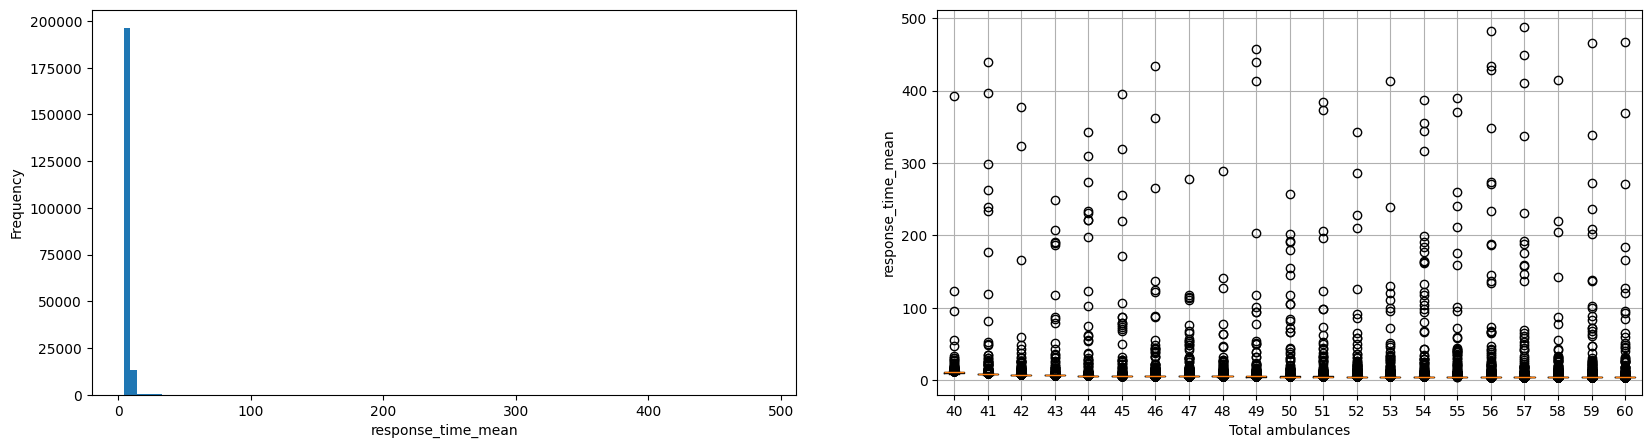

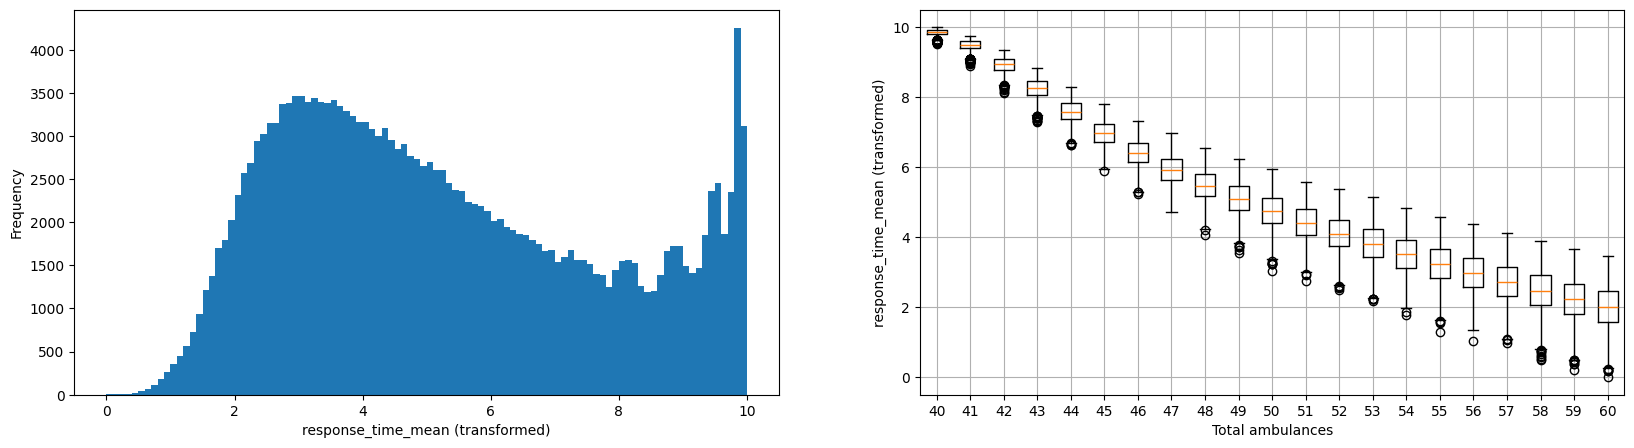

In [19]:
Y = dataset[METRICS].to_numpy()
X = dataset.drop(columns=METRICS).to_numpy()
metric = 'response_time_mean'
y = Y[:, METRICS.index(metric)]
plot_metric(X, y, metric)
X, y = remove_outliers_at_each_ambulance_count(X, y, percent=5, tail='right')
y = scipy.stats.boxcox(y)[0]
y = rescale(y, 0, 10)
plot_metric(X, y, f'{metric} (transformed)')

In [20]:
X_pt = torch.tensor(X, dtype=torch.float32, device=device)
y_pt = torch.tensor(y, dtype=torch.float32, device=device)
mlp = MLP(
    in_dim=X_pt.shape[1],
    hidden_dims=[200, 200],
    name='toronto_pmedian'
).to(device)

# Begin training with Adam
mlp.fit(X_pt, y_pt)

# Set dropout to 0 and continue training with Adam
mlp.set_dropout(0)
mlp.fit(X_pt, y_pt)

# Switch to SGD with momentum and continue training
mlp.set_optimizer_and_lr_scheduler(
    optimizer=torch.optim.SGD,
    optimizer_params={'momentum': 0.9},
    lr_scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau,
    lr_scheduler_params={'patience': 5}
)
mlp.fit(X_pt, y_pt)
mlp.save_npz()

 27%|██▋       | 27/100 [01:36<04:21,  3.58s/epoch, best_val_loss=0.0744, train_loss=0.232, val_loss=0.302]


Early stopping


 85%|████████▌ | 85/100 [04:58<00:52,  3.52s/epoch, best_val_loss=0.019, train_loss=0.0204, val_loss=0.0228] 


Early stopping


 76%|███████▌  | 76/100 [04:05<01:17,  3.24s/epoch, best_val_loss=0.0164, train_loss=0.0154, val_loss=0.0164]

Early stopping


In [21]:
weights, biases = MLP.load_npz('toronto_pmedian.npz')
solution = mlp_based_model(
    n_ambulances=N_AMBULANCES,
    optimization_sense=GRB.MINIMIZE,
    weights=weights,
    biases=biases,
    facility_capacity=FACILITY_CAPACITY,
    time_limit=TIME_LIMIT,
    verbose=True
)
print(f"Optimal solution: {solution}\nTotal ambulances used: {sum(solution)}")
results = sim.run(solution)
results

Set parameter TimeLimit to value 60
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: AMD Ryzen 5 3600 6-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1653 rows, 1292 columns and 52144 nonzeros
Model fingerprint: 0xf3859ec3
Variable types: 1046 continuous, 246 integer (200 binary)
Coefficient statistics:
  Matrix range     [2e-06, 2e+01]
  Objective range  [2e-01, 2e+00]
  Bounds range     [1e+00, 5e+00]
  RHS range        [7e-04, 5e+01]
Presolve removed 661 rows and 455 columns
Presolve time: 0.07s
Presolved: 992 rows, 837 columns, 50422 nonzeros
Variable types: 594 continuous, 243 integer (197 binary)
Found heuristic solution: objective 13.5633125
Found heuristic solution: objective 12.4116764

Root relaxation: objective 5.443755e-01, 286 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unex

,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,0.842026,0.990253,0.089241,4.870670,4.511783,7.665127,0.443064,23.879235
1,0.838122,0.989934,0.088854,4.895607,4.519414,7.708885,0.448360,23.736298
2,0.839712,0.990428,0.088920,4.887103,4.517700,7.702666,0.446089,23.875751
3,0.839534,0.990591,0.089167,4.880106,4.509445,7.703730,0.445382,23.757998
4,0.839943,0.989634,0.088744,4.903075,4.526368,7.734464,0.447341,23.746705


In [22]:
model_name = 'MLP-pMedian'
n_ambulances = solution.sum()
y = results.mean()
new_row = [model_name, n_ambulances, *[y[metric] for metric in METRICS]]
all_results.append(new_row)

pd.DataFrame(all_results, columns=['model_name', 'n_ambulances', *METRICS])

,model_name,n_ambulances,coverage_9min,coverage_15min,survival_rate,response_time_mean,response_time_median,response_time_90th_percentile,busy_fraction,service_rate
0,best_coverage_9min,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
1,best_survival_rate,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
2,best_response_time_mean,50,0.855278,0.991371,0.092727,4.687873,4.302999,7.480277,0.436943,23.824098
3,MEXCLP,50,0.856430,0.989984,0.093651,4.661749,4.241825,7.507936,0.445115,23.892860
4,p-Median + Queueing,50,0.654726,0.954248,0.067960,6.437952,5.744128,10.612214,0.474050,22.395953
5,MLP-Coverage,50,0.859884,0.990856,0.094279,4.624977,4.222090,7.415972,0.445116,23.875520
6,MLP-Survival,50,0.860076,0.991046,0.094750,4.615740,4.202265,7.439145,0.440620,23.910870
7,MLP-pMedian,50,0.839867,0.990168,0.088985,4.887312,4.516942,7.702975,0.446047,23.799197
